# Train a BNN to classify MNIST

In [1]:
%load_ext autoreload
import sys
sys.path.append("../../learning_particle_gradients/")
from functools import partial
from itertools import cycle


import numpy as onp
import jax
from jax import numpy as jnp
from jax import jit, grad, value_and_grad, vmap, config, random
config.update("jax_debug_nans", False)
from jax.ops import index_update, index
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

import haiku as hk
import optax

import nets
import utils

key = random.PRNGKey(0)


# Data
import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_classes = info.features['label'].num_classes
# h, w, c = info.features['image'].shape
# num_pixels = h * w * c

# Full train and test set
train_images, train_labels = train_data['image'], train_data['label']
test_images, test_labels = test_data['image'], test_data['label']

# validation set
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=0)
data_size = len(train_images)
BATCH_SIZE = 128



def make_batches(images, labels, batch_size):
    """Returns an iterator that cycles through 
    tuples (image_batch, label_batch)."""
    num_batches = len(images) // batch_size
    split_idx = onp.arange(1, num_batches+1)*batch_size
    batches = zip(*[onp.split(data, split_idx, axis=0) for data in (images, labels)])
    return cycle(batches)


@jit
def accuracy(logits, labels):
    """
    Args:
        logits: [batch, num_classes] float array.
        labels: categorical labels [batch,] int array (not one-hot).
    """
    preds = jnp.argmax(logits, axis=1)
    return jnp.mean(preds==labels)


def crossentropy_loss(logits, labels, label_smoothing=0.):
    """Compute cross entropy for logits and labels w/ label smoothing
    Args:
        logits: [batch, num_classes] float array.
        labels: categorical labels [batch,] int array (not one-hot).
        label_smoothing: label smoothing constant, used to determine the on and off values.
    """
    num_classes = logits.shape[-1]
    labels = jax.nn.one_hot(labels, num_classes)
    if label_smoothing > 0:
        labels = labels * (1 - label_smoothing) + label_smoothing / num_classes
    logp = jax.nn.log_softmax(logits)
    return -jnp.sum(logp * labels) # summed loss over batch 
                                   # equal to model_loglikelihood(data | params)


def log_prior(params):
    """prior used to regularize weights (same as initialization).
    unscaled."""
    logp_tree = jax.tree_map(lambda param: - param**2 / 100**2 / 2, params)
#         lambda param: jax.scipy.stats.norm.logpdf(param, loc=0, scale=1/100),
#         params)
    return jax.tree_util.tree_reduce(lambda x, y: jnp.sum(x)+jnp.sum(y), logp_tree)


def loss(params, images, labels):
    """Minibatch approximation of the (unnormalized) Bayesian
    negative log-posterior evaluated at `params`."""
    logits = model.apply(params, images)
    return data_size/BATCH_SIZE * crossentropy_loss(logits, labels) -  log_prior(params) # ie -log model_likelihood(data_batch | params) * batch_rescaling_constant - log prior(params))

In [2]:
# Classifier network
initializer = hk.initializers.RandomNormal(stddev=1 / 100)
# initializer = None

def model_fn(image):
    image = image.astype(jnp.float32)
    convnet = hk.Sequential([
        hk.Conv2D(32, kernel_shape=(3,3), w_init=initializer, b_init=initializer),
        jax.nn.relu,
        hk.MaxPool(window_shape=(2,2), strides=2, padding="VALID"),

        hk.Conv2D(64, kernel_shape=(3,3), w_init=initializer, b_init=initializer),
        jax.nn.relu,
        hk.MaxPool(window_shape=(2,2), strides=2, padding="VALID"),

        hk.Flatten(),
        hk.Linear(num_classes, w_init=initializer, b_init=initializer),
    ])
    return convnet(image)

model = hk.without_apply_rng(hk.transform(model_fn))

# initialization
# key, subkey = random.split(key)
# init_params = model.init(subkey, train_images[:128])
# logits = model.apply(init_params, train_images[:128])

# print(logits.shape)
# print(jnp.argmax(logits, axis=1))

# Classic (non-Bayesian) training
* Train a classifier using SGD. 
* To be consistent with the BNN approach, all parameters (including biases) are initialized as $N(0, 1/100^2)$ (ie the prior).
* The training loss is $L^2$-regularized, corresponding roughly to the maximum a posteriori estimator with the normal prior.

In [17]:
batch_size = 128
learning_rate = 1e-7
# opt = optax.sgd(learning_rate)
opt = utils.sgld(learning_rate)

@jit
def step(params, opt_state, images, labels):
    step_loss, g = value_and_grad(loss)(params, images, labels)
    g, opt_state = opt.update(g, opt_state, params)
    return optax.apply_updates(params, g), opt_state, step_loss

@jit
def compute_accuracy(params):
    return accuracy(model.apply(params, val_images[:batch_size]), val_labels[:batch_size])


batches = make_batches(train_images, train_labels, batch_size)
key, subkey = random.split(key)
params = model.init(subkey, train_images[:2])
opt_state = opt.init(params)

ls = []
ces = []
accs = []

In [18]:
for step_count in tqdm(range(100)):
    images, labels = next(batches)
    params, opt_state, step_loss = step(params, opt_state, images, labels)
    ls.append(step_loss)
#     ces.append(ce)

#     if step_count % 100 == 0:
#         current_acc = compute_accuracy(params)
#         accs.append(current_acc)
#         print(current_acc)

100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


0.921875


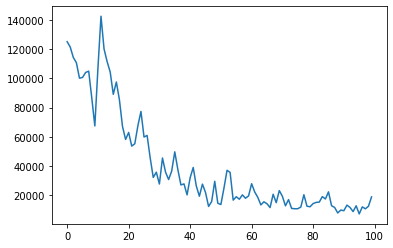

In [6]:
# SGD, lr=1e-7
plt.plot(ls)
print(compute_accuracy(params))

0.921875


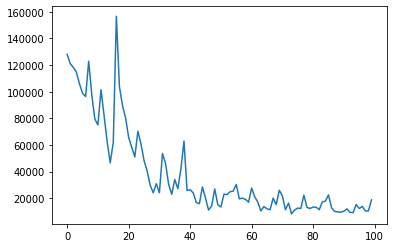

In [19]:
# SGLD, lr=1e-7
plt.plot(ls)
print(compute_accuracy(params))

# Bayesian training with parallel Langevin dynamics

In [29]:
batch_size = 128
learning_rate = 1e-7
opt = utils.sgld(learning_rate)

# schedule_fn = optax.polynomial_schedule(
#     init_value=-learning_rate, end_value=-learning_rate/10, power=1, transition_steps=200)
# schedule_fn = optax.constant_schedule(-learning_rate)
# key, subkey = random.split(key)
# opt = utils.scaled_sgld(subkey)
# opt = optax.sgd(learning_rate)

@jit
def step(param_set, opt_state, images, labels):
    """Update param_set elements in parallel using Langevin dynamics."""
    step_losses, g = vmap(value_and_grad(loss), (0, None, None))(param_set, images, labels)
    g, opt_state = opt.update(g, opt_state, param_set)
    return optax.apply_updates(param_set, g), opt_state, step_losses


@jit
def ensemble_accuracy(param_set):
    """use ensemble predictions to compute validation accuracy"""
    vapply = vmap(model.apply, (0, None))
    logits = vapply(param_set, val_images[:batch_size])
    preds = jnp.mean(vmap(jax.nn.softmax)(logits), axis=0) # mean prediction
    return jnp.mean(preds.argmax(axis=1) == val_labels[:batch_size])


# initialize set of parameters
num_samples = 15
key, subkey = random.split(key)
init_param_set = vmap(model.init, (0, None))(random.split(subkey, num_samples), train_images[:5])

batches = make_batches(train_images, train_labels, batch_size)
param_set = init_param_set
opt_state = opt.init(param_set)
ls = []
accs = []

In [23]:
# training loop
for batch_idx in tqdm(range(121)):
    images, labels = next(batches)
    param_set, opt_state, step_losses = step(param_set, opt_state, images, labels)
    ls.append(step_losses)

    if batch_idx % 60 == 0:
        accs.append(ensemble_accuracy(param_set))
        print(accs[-1])

100%|██████████| 100/100 [04:29<00:00,  2.69s/it]


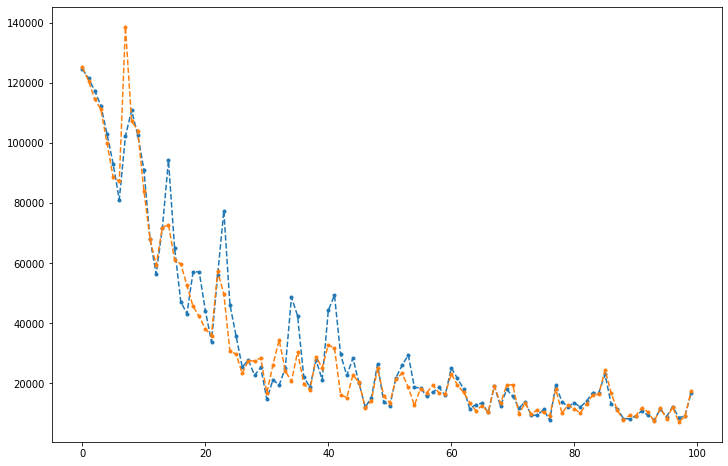

In [24]:
fig, ax = plt.subplots(figsize=[12,8])
plt.plot(ls, "--.");

In [28]:
acc = ensemble_accuracy(param_set)
print(acc)

0.9140625


In [26]:
# individual accuracies
vmap(accuracy, (0, None))(logits, val_labels[:batch_size])

DeviceArray([0.3515625, 0.46875  ], dtype=float32)